# MTE 544 Report

|Stephen Wang|Ajit Rakhra|Howard Dong|
|:-:|:-:|:-:|
|x2274wan|a3rakhra|h53dong|
|20821034|20832703|20847639|

Station 1, Robot 4 on Fri Oct 20 at 8:30 AM

In [2]:
%config InlineBackend.figure_formats = ["svg"]

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def get_data(name, parse=True):
    with open(name) as f:
        f.readline()
        data = f.read()
    if parse:
        return np.fromstring(data, sep=", ")
    else:
        return data

In [14]:
p_data = get_data("robot_pose.p.csv").reshape(-1, 4)

In [36]:
def plot_trajectory_to_point(x, y, goal, title):
    plt.grid()
    plt.plot(x, y, marker="o", markersize=2, label="Robot Odometry")

    plt.plot([x[0], goal[0]], [y[0], goal[1]], label="Desired Trajectory")

    plt.plot(x[0], y[0], marker="o", markersize=10, label="Start")

    plt.plot(*goal, marker="o", markersize=10, label="Goal")
    
    plt.axis("scaled")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

For point control, When comparing the trajectory and state variables of the robot motion under P and PID control, it can be seen that PID control provides a better trajectory. The x and y trajectories seem to be very similar, but one noticeable difference is between the theta values. Though both controllers result in steady-state error, PID control mitigates the overshoot of theta.

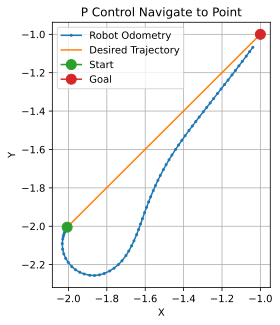

In [37]:
plot_trajectory_to_point(p_data[:,0], p_data[:,1], (-1, -1), "P Control Navigate to Point")

In [32]:
pid_data = get_data("robot_pose.pid.csv").reshape(-1, 4)

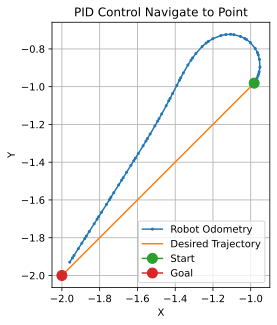

In [38]:
plot_trajectory_to_point(pid_data[:,0], pid_data[:,1], (-2, -2), "PID Control Navigate to Point")

In [88]:
def plot_states_over_time(x, y, theta, t, goal_point, theta_goal):
    t = (t - t[0]) * 1e-9
    duration = t[-1]
    x_slope = goal_point[0] - x[0]
    y_slope = goal_point[1] - y[0]

    fig, axes = plt.subplots(1, 2, figsize=(12,3))
    
    axes[0].plot(t, x, marker="o", markersize=2, label="x")
    axes[0].plot(t, x_slope/duration * t + x[0], label="desired x")
    
    axes[0].plot(t, y, marker="o", markersize=2, label="y")
    axes[0].plot(t, y_slope/duration * t + y[0], label="desired y")

    axes[0].grid()
    axes[0].legend()
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Position (m)")
    axes[0].set_title("Robot States Over Time")

    axes[1].plot(t, theta, marker="o", markersize=2, label=r"$\theta$")
    axes[1].plot([t[0], t[-1]], [theta_goal]*2, label=r"$\theta$ goal")
    
    axes[1].grid()
    axes[1].legend()
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Angle (rad)")
    axes[1].set_title("Robot Heading Over Time")

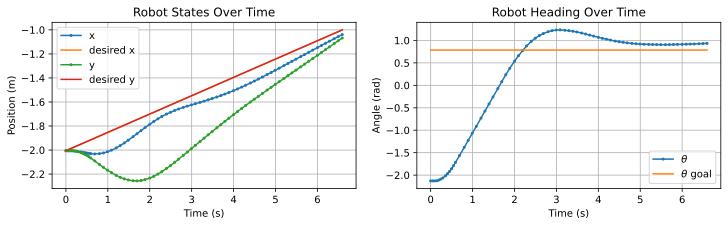

In [89]:
plot_states_over_time(*p_data.T, (-1, -1), np.pi/4)

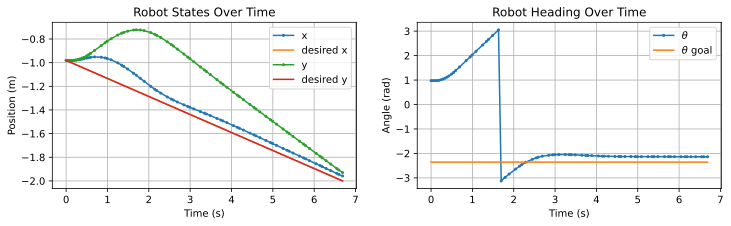

In [90]:
plot_states_over_time(*pid_data.T, (-2, -2), -3*np.pi/4)

We also observed that trajectories densely sampled from the reference functions, at 100 points, the robot oscillated uncontrollably; changing the PID parameters did not reduce the oscillations.
We theorized that that there was a very significant amount of latency between the controller and the robot, ie the plant.
Thus, we ensured that there were no more than 21 points in the reference trajectory.
The resultant odometry plots, as shown below, are satisfactory, with the parameters tuned from point-to-point navigation.

In [92]:
def plot_trajectory(x, y, ref_x, ref_y, title):
    plt.plot(x, y, marker="o", markersize=2, label="robot odometry")
    plt.plot(ref_x, ref_y, marker="o", markersize=2, label="reference trajectory")
    plt.axis("scaled")
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [109]:
parabola_data = get_data("robot_pose.parabola.csv").reshape(-1, 4)
parabola_ref = np.load("parabola.npz")
parabola_ref_x = parabola_ref.get("arr_0")
parabola_ref_y = parabola_ref.get("arr_1")

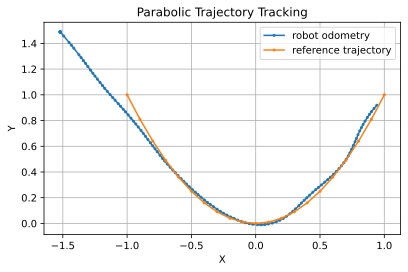

In [110]:
plot_trajectory(parabola_data[:,0], parabola_data[:,1], parabola_ref_x, parabola_ref_y, "Parabolic Trajectory Tracking")

In [116]:
def plot_trajectory_error(x, y, func, title):
    plt.grid()
    plt.plot(x, func(x) - y, marker="o", markersize=2)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

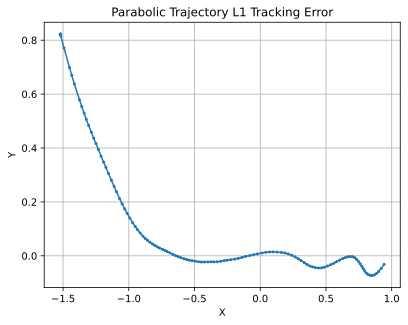

In [117]:
plot_trajectory_error(parabola_data.T[0], parabola_data.T[1], lambda x : x**2, "Parabolic Trajectory L1 Tracking Error")

In [93]:
sigmoid_data = get_data("robot_pose.sigmoid.csv").reshape(-1, 4)
sigmoid_ref = np.load("sigmoid.npz")

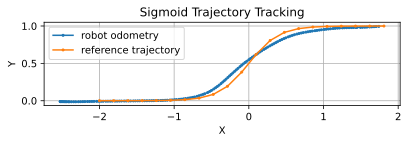

In [102]:
plot_trajectory(sigmoid_data[:,0], sigmoid_data[:,1], sigmoid_ref.get("arr_0"), sigmoid_ref.get("arr_1"), "Sigmoid Trajectory Tracking")

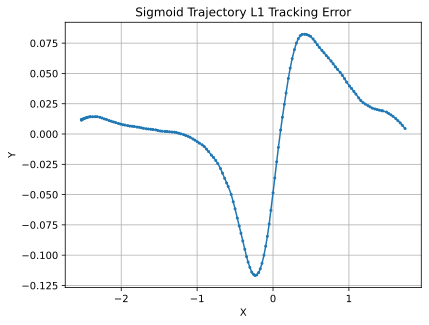

In [119]:
plot_trajectory_error(sigmoid_data.T[0], sigmoid_data.T[1], lambda x : 1 / (np.exp(-5*x) + 1), "Sigmoid Trajectory L1 Tracking Error")

The sigmoid trajectory illustrates the limitation of using PID for steering control.
The reference signal is exclusively based on (up to, if at the end) the third next point in the trajectory, without considering the possible curvature that intermediate points would create.
This resulted in an odometry trajectory that conforms to the general shape of the function but it looks like $ \frac{1}{1+e^{-3x}} $ rather than $ \frac{1}{1+e^{-5x}} $.

Depending on the application, this may not be consequential. However, if the trajectory was planned to optimize a very specific objective, failing to follow the trajectory exactly would produce a suboptimal path.